In [1]:
import torch
import numpy as np
import pandas as pd
from obspy import read
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [2]:
cat_directory = './data/lunar/training/catalogs/'
cat_file = cat_directory + 'apollo12_catalog_GradeA_final.csv'
cat = pd.read_csv(cat_file)

def data_extrac(N=27, data_directory = './data/lunar/training/data/S12_GradeA/'):
    '''
    Extrae los datos de un archivo N del catalogo y filtra por bandpass
    ademas mas cositas (proximamente)
    '''

    #Obtener le ubicacion de los datos de una señal
    row = cat.iloc[N]          #señal N (27)

    test_filename = row.filename
    arrival_time_rel = row['time_rel(sec)']

    #Obtener datos de la señal
    mseed_file = f'{data_directory}{test_filename}.mseed'
    st = read(mseed_file)       #stream file (contains the trace(s))

    tr = st.traces[0].copy()    #Datos de la señal
    tr_times = tr.times()       #en segundos
    tr_data = tr.data
    return tr_times, tr_data, arrival_time_rel

tamaño señal 37: 572399
tamaño señal 69: 572415
tamaño señal 14: 572411
tamaño señal 17: 572423
tamaño señal 46: 572263
tamaño señal 27: 572399
tamaño señal 61: 572390
tamaño señal 20: 474915


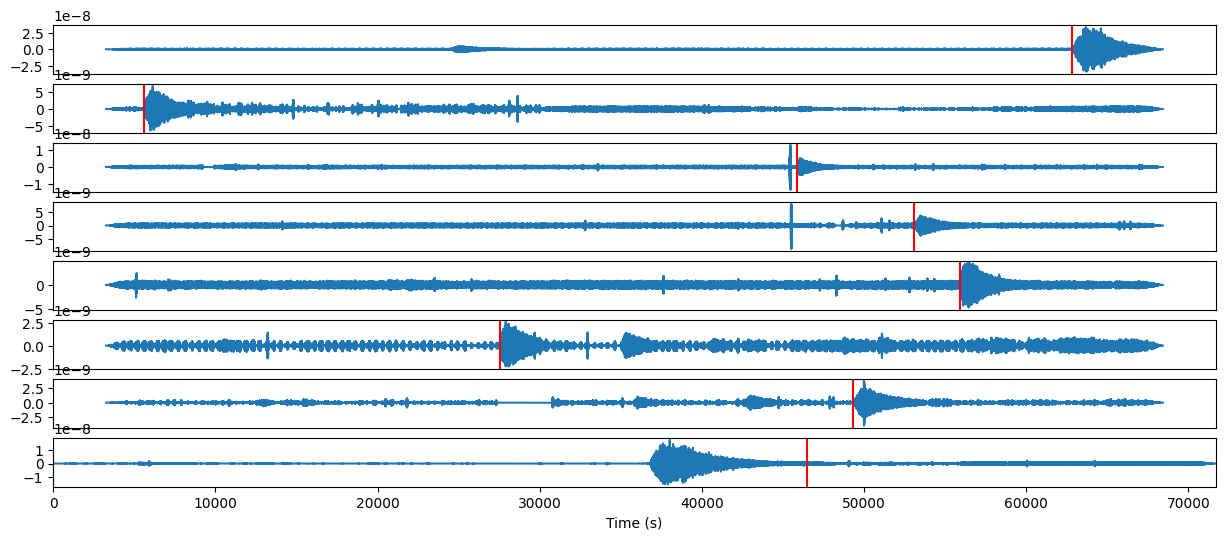

In [3]:
Ndata=8
# Initialize figure
fig,ax = plt.subplots(Ndata,1,figsize=(15,6))
for j in range(Ndata):
    i=np.random.randint(0,75)
    tr_times, tr_data, arrival = data_extrac(i)
    # Plot trace
    ax[j].plot(tr_times,tr_data)
    print(f"tamaño señal {i}:", len(tr_data))
    # Mark detection
    ax[j].axvline(x = arrival, color='red',label='Rel. Arrival')
    #ax[j].legend(loc='upper left')

    # Make the plot pretty
    ax[j].set_xticks([])
    #ax[j].set_ylabel('Velocity (m/s)')
ax[j].set_xticks(np.arange(min(tr_times), max(tr_times), 10000))
ax[j].set_xlim([min(tr_times),max(tr_times)])
ax[j].set_xlabel('Time (s)')

#ax.set_title(f'Start time: {arrival}s', fontweight='bold')
plt.show()

In [4]:
tr_times, tr_data, arrival = data_extrac(i)
print(type(tr_data[0]))

<class 'numpy.float64'>


In [5]:
# Definir el dataset personalizado
class SeismicDataset(Dataset):
    def __init__(self, catalog_csv = './data/lunar/training/catalogs/apollo12_catalog_GradeA_final.csv', data_directory = './data/lunar/training/data/S12_GradeA/', transform=None):
        self.cat = pd.read_csv(catalog_csv)
        self.data_directory = data_directory
        self.transform = transform

    def __len__(self):
        return len(self.cat)

    def __getitem__(self, idx):
        row = self.cat.iloc[idx]
        test_filename = row['filename']
        arrival_time_rel = row['time_rel(sec)']

        # Construir la ruta completa al archivo .mseed
        mseed_file = os.path.join(self.data_directory, f'{test_filename}.mseed')

        # Leer los datos de la señal
        st = read(mseed_file)
        tr = st.traces[0]
        tr_data = tr.data.astype(np.float32)  # Asegurar que los datos sean de tipo float32
        #tr_times = tr.times()  # Si necesitas los tiempos

        # Opcional: aplicar transformaciones o preprocesamiento
        if self.transform:
            tr_data = self.transform(tr_data)

        # Convertir a tensores
        signal = torch.tensor(tr_data, dtype=torch.float32)
        label = torch.tensor(arrival_time_rel, dtype=torch.float32)

        return signal, label

# Definir el modelo de CNN1D
class SeismicCNN(nn.Module):
    def __init__(self):
        super(SeismicCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=5, padding=2)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2)

        self.conv2 = nn.Conv1d(16, 32, kernel_size=5, padding=2)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=2)

        self.conv3 = nn.Conv1d(32, 64, kernel_size=5, padding=2)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool1d(kernel_size=2)

        self.dropout = nn.Dropout(0.5)

        # Agregar AdaptiveAvgPool1d para obtener una salida de tamaño fijo
        self.global_pool = nn.AdaptiveAvgPool1d(1)

        # Ahora podemos definir fc1 con una dimensión de entrada fija
        self.fc1 = nn.Linear(64, 128)
        self.relu_fc1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)  
        self.relu_fc2 = nn.ReLU()
        self.fc3 = nn.Linear(64, 32)   
        self.relu_fc3 = nn.ReLU()
        self.fc4 = nn.Linear(32, 1)

    def forward(self, x):
        # x tiene forma (batch_size, signal_length)
        x = x.unsqueeze(1)  # Añadir dimensión de canal: (batch_size, 1, signal_length)
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)

        x = self.dropout(x)

        # Aplicar AdaptiveAvgPool1d para obtener una salida de tamaño fijo
        x = self.global_pool(x)

        x = x.view(x.size(0), -1)  # Aplanar para la capa totalmente conectada

        x = self.fc1(x)
        x = self.relu_fc1(x)
        x = self.fc2(x)
        x = self.relu_fc2(x)
        x = self.fc3(x)
        x = self.relu_fc3(x)
        x = self.fc4(x)
        return x.squeeze()  # Devolver tensor de forma (batch_size)


def train_model(model, train_dataset, val_dataset, collate_fn, num_epochs=10, batch_size=32, learning_rate=0.001):
    """
    Función para entrenar el modelo.

    Parámetros:
    - model: instancia del modelo a entrenar.
    - train_dataset: Dataset de entrenamiento.
    - val_dataset: Dataset de validación.
    - collate_fn: función de collate para el DataLoader.
    - num_epochs: número de épocas de entrenamiento.
    - batch_size: tamaño del lote.
    - learning_rate: tasa de aprendizaje.
    """
    # Crear DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=collate_fn)

    # Definir criterio de pérdida y optimizador
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Mover el modelo al dispositivo adecuado
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Listas para almacenar las pérdidas
    train_losses = []
    val_losses = []

    # Ciclo de entrenamiento
    for epoch in range(num_epochs):
        # Entrenamiento
        model.train()
        running_loss = 0.0
        for batch_signals, batch_labels in train_loader:
            batch_signals = batch_signals.to(device)
            batch_labels = batch_labels.to(device)

            
            outputs = model(batch_signals)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            running_loss += loss.item() * batch_signals.size(0)

        epoch_loss = running_loss / len(train_dataset)
        train_losses.append(epoch_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}')

        # Validación
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_signals, batch_labels in val_loader:
                batch_signals = batch_signals.to(device)
                batch_labels = batch_labels.to(device)

                outputs = model(batch_signals)
                loss = criterion(outputs, batch_labels)
                val_loss += loss.item() * batch_signals.size(0)

        val_epoch_loss = val_loss / len(val_dataset)
        val_losses.append(val_epoch_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_epoch_loss:.4f}')

    return model, train_losses, val_losses



In [12]:
if __name__ == '__main__':
    # Rutas a los archivos y directorios
    cat_directory = './data/lunar/training/catalogs/'
    cat_file = os.path.join(cat_directory, 'apollo12_catalog_GradeA_final.csv')
    data_directory = './data/lunar/training/data/S12_GradeA/'

    # Crear el Dataset completo
    full_dataset = SeismicDataset(catalog_csv=cat_file, data_directory=data_directory)
    print("tamaño del dataset: ", len(full_dataset))######################################################
    
    # Dividir en conjuntos de entrenamiento y validación
    train_indices, val_indices = train_test_split(np.arange(len(full_dataset)), test_size=0.2, random_state=42)
    train_dataset = Subset(full_dataset, train_indices)
    val_dataset = Subset(full_dataset, val_indices)
    print("tamaño del dataset_train: ",len(train_dataset))######################################################
    print("tamaño del val_dataset: ",len(val_dataset))######################################################

    # Definir la función de collate personalizada
    def collate_fn(batch):
        signals, labels = zip(*batch)
        max_length = max(signal.shape[0] for signal in signals)
        padded_signals = []
        for signal in signals:
            pad_size = max_length - signal.shape[0]
            padded_signal = torch.nn.functional.pad(signal, (0, pad_size))
            padded_signals.append(padded_signal)
        signals_tensor = torch.stack(padded_signals)
        labels_tensor = torch.stack(labels)
        return signals_tensor, labels_tensor

    train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=4, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False, num_workers=4, collate_fn=collate_fn)

    print("tamaño del train_loader: ",len(train_dataset))######################################################
    print("tamaño del val_loader: ",len(val_loader))######################################################
    signal, label = full_dataset[0]
    print(signal.shape)
    print(label)


    # Inicializar el modelo
    model = SeismicCNN()

    # Entrenar el modelo utilizando la función modularizada
    trained_model, train_losses, val_losses  = train_model(
        model=model,
        train_dataset=train_dataset,
        val_dataset=val_dataset,
        collate_fn=collate_fn,
        num_epochs=20,
        batch_size=10,
        learning_rate=0.01
    )

    # Guardar el modelo entrenado
    torch.save(trained_model.state_dict(), 'seismic_cnn_model.pth')

tamaño del dataset:  76
tamaño del dataset_train:  60
tamaño del val_dataset:  16
tamaño del train_loader:  60
tamaño del val_loader:  2
torch.Size([572415])
tensor(73500.)
Epoch 1/20, Training Loss: 2499468352.0000
Epoch 1/20, Validation Loss: 1946944784.0000
Epoch 2/20, Training Loss: 2497198720.0000
Epoch 2/20, Validation Loss: 1938530416.0000
Epoch 3/20, Training Loss: 2453235264.0000
Epoch 3/20, Validation Loss: 1820129344.0000
Epoch 4/20, Training Loss: 2054479744.0000
Epoch 4/20, Validation Loss: 1055729336.0000
Epoch 5/20, Training Loss: 908952666.6667
Epoch 5/20, Validation Loss: 1292673824.0000
Epoch 6/20, Training Loss: 769722618.6667
Epoch 6/20, Validation Loss: 654214800.0000
Epoch 7/20, Training Loss: 750558826.6667
Epoch 7/20, Validation Loss: 636789056.0000
Epoch 8/20, Training Loss: 662803632.0000
Epoch 8/20, Validation Loss: 822677864.0000
Epoch 9/20, Training Loss: 646210528.0000
Epoch 9/20, Validation Loss: 641811232.0000
Epoch 10/20, Training Loss: 637051008.0000
E

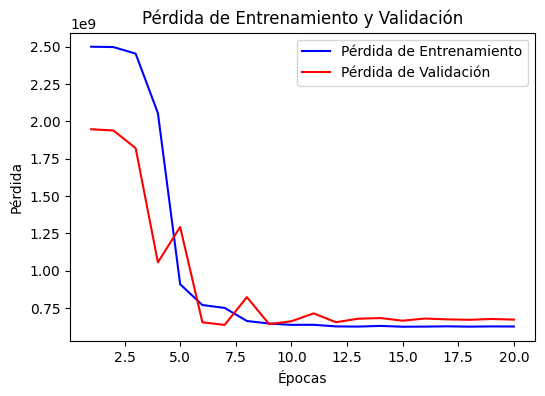

In [13]:
# Graficar las pérdidas
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(6, 4))
plt.plot(epochs, train_losses, 'b', label='Pérdida de Entrenamiento')
plt.plot(epochs, val_losses, 'r', label='Pérdida de Validación')
plt.title('Pérdida de Entrenamiento y Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

In [8]:
model = SeismicCNN()
model.load_state_dict(torch.load('seismic_cnn_model.pth', weights_only=True))

# Configurar el modelo en modo evaluación
model.eval()

# Mover el modelo al dispositivo adecuado (si no lo has hecho)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Listas para almacenar predicciones y etiquetas reales
all_predictions = []
all_labels = []

for i in range(50):
    j = np.random.randint(0, 75)
    tr_times, tr_data, arrival_time_rel = data_extrac(j)
    
    # Convertir la señal a tensor y añadir dimensiones de batch y canal
    signal = torch.tensor(tr_data, dtype=torch.float32).unsqueeze(0)
    signal = signal.to(device)  # Mover al dispositivo adecuado (CPU o GPU)

    all_labels.append(arrival_time_rel)

    # Pasar la señal por el modelo
    output = model(signal)
    all_predictions.append(output.cpu().detach().numpy())  # Mover a CPU si está en GPU y convertir a numpy



Error Medio Absoluto (MAE): 20536.2555
Error Cuadrático Medio (MSE): 604350524.5472
Coeficiente de Determinación (R^2): -0.0021


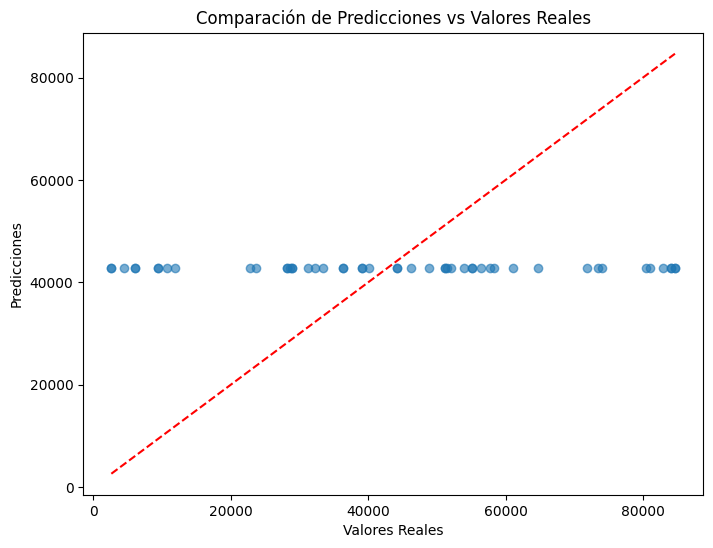

In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(all_labels, all_predictions)
mse = mean_squared_error(all_labels, all_predictions)
r2 = r2_score(all_labels, all_predictions)

print(f'Error Medio Absoluto (MAE): {mae:.4f}')
print(f'Error Cuadrático Medio (MSE): {mse:.4f}')
print(f'Coeficiente de Determinación (R^2): {r2:.4f}')
# Convertir las listas a arrays de NumPy para facilitar el manejo
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

# Crear la gráfica
plt.figure(figsize=(8, 6))
plt.scatter(all_labels, all_predictions, alpha=0.6)
plt.plot([all_labels.min(), all_labels.max()], [all_labels.min(), all_labels.max()], 'r--')  # Línea de referencia
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Comparación de Predicciones vs Valores Reales')
plt.show()